# Comparaison extension neige pour la limite à 0,85°C (période de référence) fichier initial de sortie et celui avec la nouvelle grille

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import xesmf as xe
import matplotlib.pyplot as plt

/srv/conda/envs/notebook/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


## Test pour un modèle

### Fichier initial

In [2]:
path_ini_BCC_CSM2 = os.path.join("~/private-storage/SnowWarming/", "SnowWarming_BCC-CSM2-MR_historical+ssp585.nc")

In [3]:
ini_BCC_CSM2 = xr.open_dataset(path_ini_BCC_CSM2)
ini_BCC_CSM2

<xarray.Dataset> Size: 69MB
Dimensions:  (month: 12, GSAT: 23, lat: 160, lon: 320, Level: 5)
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float32 92B -0.5 -0.25 0.0 0.25 0.5 ... 4.25 4.5 4.75 5.0
  * lat      (lat) float32 640B -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
  * lon      (lon) float32 1kB 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
  * Level    (Level) float32 20B 10.0 25.0 50.0 75.0 90.0
Data variables:
    sncbin   (GSAT, month, lat, lon) float32 57MB ...
    Limit    (Level, month, lat, lon) float32 12MB ...

#### Ici je regarde les limites

In [4]:
print(ini_BCC_CSM2["Limit"].dims)
print(ini_BCC_CSM2["Limit"].coords)

('Level', 'month', 'lat', 'lon')
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * lat      (lat) float32 640B -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
  * lon      (lon) float32 1kB 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
  * Level    (Level) float32 20B 10.0 25.0 50.0 75.0 90.0


In [5]:
limit = ini_BCC_CSM2["Limit"].sel(month=8, Level=50.0)

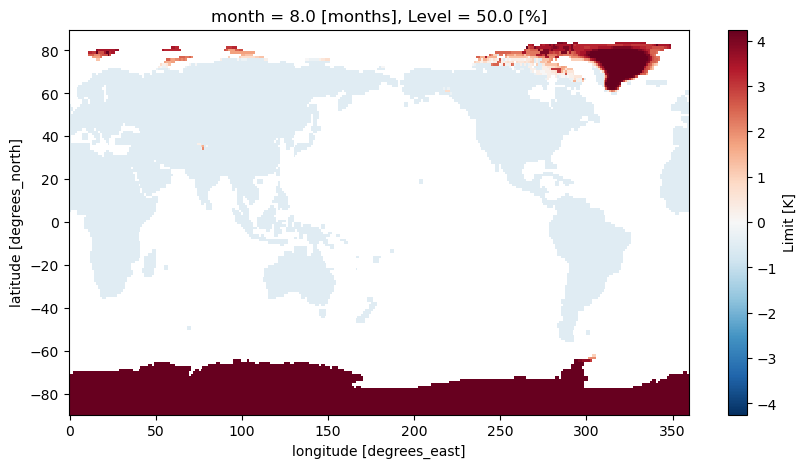

In [6]:
plt.figure(figsize=(10, 5))
limit.plot()

#### Ici je regarde pour le niveau de référence

<span style="color:red"> Pourquoi tous les mois ne s'affichent pas ???</span>

In [7]:
print(ini_BCC_CSM2["sncbin"].dims)
print(ini_BCC_CSM2["sncbin"].coords)

('GSAT', 'month', 'lat', 'lon')
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float32 92B -0.5 -0.25 0.0 0.25 0.5 ... 4.25 4.5 4.75 5.0
  * lat      (lat) float32 640B -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
  * lon      (lon) float32 1kB 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9


In [8]:
sncbin = ini_BCC_CSM2["sncbin"].sel(GSAT=0.75, month=3)

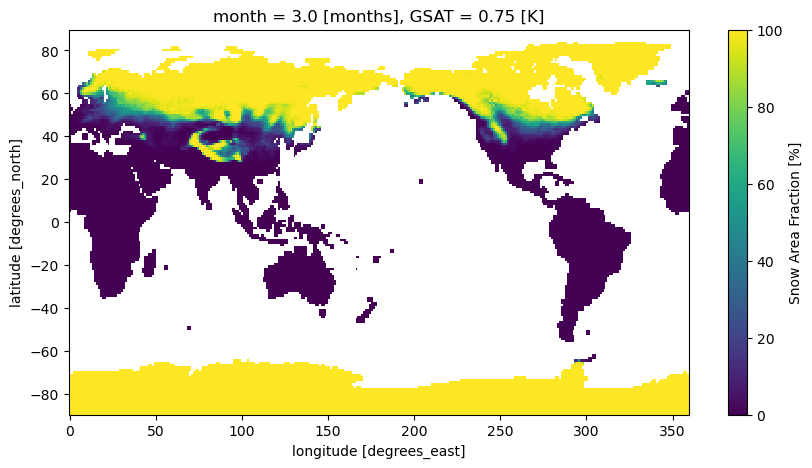

In [9]:
plt.figure(figsize=(10, 5))
sncbin.plot()

In [26]:
# Interpolation pour obtenir la valeur à GSAT = 0.85
sncbin_interpolated = ini_BCC_CSM2["sncbin"].interp(GSAT=0.85, month=12)

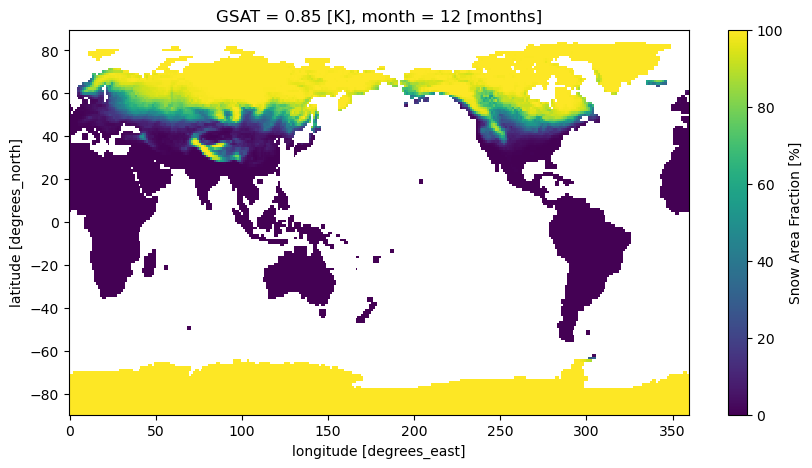

In [27]:
plt.figure(figsize=(10, 5))
sncbin_interpolated.plot()

In [21]:
# Ou manuellement

at_0_75 = ini_BCC_CSM2["sncbin"].sel(GSAT=0.75, month=3)
at_1_0 = ini_BCC_CSM2["sncbin"].sel(GSAT=1.0, month=3)

interpolated_value = at_0_75 + (0.85 - 0.75) * (at_1_0 - at_0_75) / (1.0 - 0.75)

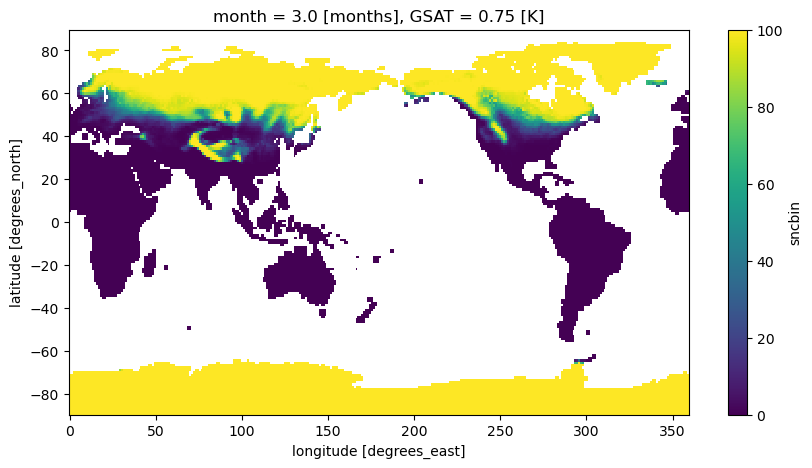

In [22]:
plt.figure(figsize=(10, 5))
interpolated_value.plot()

In [23]:
sncbin_interpolated

<xarray.DataArray 'sncbin' (lat: 160, lon: 320)> Size: 410kB
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * lat      (lat) float32 640B -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
  * lon      (lon) float32 1kB 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
    GSAT     float64 8B 0.85
    month    int64 8B 6
Attributes:
    units:          %
    standard_name:  surface_snow_area_fraction
    long_name:      Snow Area Fraction

#### Pour obtenir les valeurs numériques, je dois multiplier par l'aire des cellules

In [28]:
path_areacella_BCC_CSM2 = os.path.join("/home/jovyan/private-storage/masques/masques/pseudo_areacella/", "areacella_BCC-CSM2-MR.nc")

areacella_BCC_CSM2 = xr.open_dataset(path_areacella_BCC_CSM2)

In [29]:
cell_area = areacella_BCC_CSM2["areacella"]


snow_cover_km2 = (sncbin_interpolated / 100 * (cell_area * 1e-6) ).sum(dim=["lat", "lon"], skipna=True)
snow_cover_km2

<xarray.DataArray ()> Size: 8B
array(52165154.37200288)
Coordinates:
    GSAT     float64 8B 0.85
    month    int64 8B 12

### Fichier interpolé

In [39]:
path_interp_BCC_CSM2 = os.path.join("~/private-storage/interp_models_SW/", "BCC-CSM2-MR_SW_reprojete.nc")

In [40]:
interp_BCC_CSM2 = xr.open_dataset(path_interp_BCC_CSM2)
interp_BCC_CSM2

<xarray.Dataset> Size: 87MB
Dimensions:  (GSAT: 23, month: 12, lat: 180, lon: 360, Level: 5)
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float32 92B -0.5 -0.25 0.0 0.25 0.5 ... 4.25 4.5 4.75 5.0
  * Level    (Level) float32 20B 10.0 25.0 50.0 75.0 90.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    sncbin   (GSAT, month, lat, lon) float32 72MB ...
    Limit    (Level, month, lat, lon) float32 16MB ...
Attributes:
    regrid_method:  nearest_s2d

In [45]:
sncbin_interp = interp_BCC_CSM2["sncbin"].interp(GSAT=0.85, month=4)

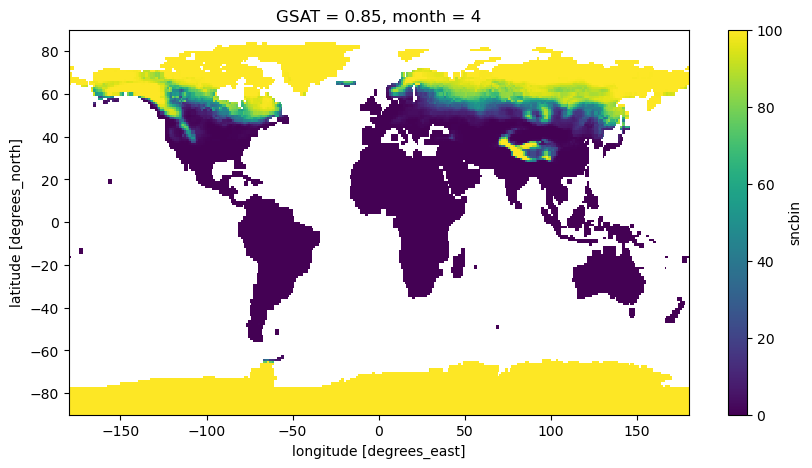

In [46]:
plt.figure(figsize=(10, 5))
sncbin_interp.plot()

In [49]:
sncbin_interp

<xarray.DataArray 'sncbin' (lat: 180, lon: 360)> Size: 518kB
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    GSAT     float64 8B 0.85
    month    int64 8B 4

In [47]:
path_areacella_interp_BCC_CSM2 = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", "BCC-CSM2-MR_gridarea_hist_recalcule.nc")

areacella_interp_BCC_CSM2 = xr.open_dataset(path_areacella_interp_BCC_CSM2)

In [48]:
cell_area_interp = areacella_interp_BCC_CSM2["cell_area"]

snow_cover_km2 = (sncbin_interp / 100 * (cell_area_interp * 1e-6) ).sum(dim=["lat", "lon"], skipna=True)
snow_cover_km2

<xarray.DataArray ()> Size: 8B
array(45816133.27920269)
Coordinates:
    GSAT     float64 8B 0.85
    month    int64 8B 4